In [274]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

sns.color_palette("pastel")
palette=sns.set_style("whitegrid")


# Reading input files

In [275]:
def read_input():
    crimes_df = pd.read_pickle("Cleaned_Crimes_dataframe.pkl")
    census_df = pd.read_pickle("Cleaned_Census_dataframe.pkl")
    return crimes_df,census_df

In [276]:
crimes_df,census_df=read_input()

In [277]:
crimes_df_date = pd.Series(crimes_df.index)
crimes_df_date = pd.to_datetime(crimes_df_date)
crimes_df['day'] = list(crimes_df_date.dt.day_name())
crimes_df['month'] = list(crimes_df_date.dt.month_name())
crimes_df['hour'] = list(crimes_df_date.dt.hour)


In [278]:
def create_mappings(mapping_dict,dataFrame,attribute):
    mapping_cols={}
    for parent_category, child in mapping_dict.items():
        for key in parent_category:
            mapping_cols[key] = child

    dataFrame[attribute] = dataFrame[attribute].map(mapping_cols)
    return dataFrame


In [279]:

grouped_crime_dict = {}
crimes_dict = {  
    ('CRIMINAL TRESPASS','CRIMINAL DAMAGE','DECEPTIVE PRACTICE','HOMICIDE') : 'CRIMINAL_OFFENSE',
    ('KIDNAPPING','HUMAN TRAFFICKING','OFFENSE INVOLVING CHILDREN') : 'HUMAN_TRAFFICKING_OFFENSE',
    ('NARCOTICS','OTHER NARCOTIC VIOLATION') : 'NARCOTIC_OFFENSE',
    ('BURGLARY','MOTOR VEHICLE THEFT','THEFT','ROBBERY') : 'THEFT',
    ('BATTERY','ASSAULT','NON-CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)') : 'NON-CRIMINAL_ASSAULT',
    ('CRIM SEXUAL ASSAULT','SEX OFFENSE','STALKING','PROSTITUTION') : 'SEXUAL_OFFENSE',
    ('WEAPONS VIOLATION','CONCEALED CARRY LICENSE VIOLATION') :  'WEAPONS_OFFENSE',
    ('OTHER OFFENSE','ARSON','GAMBLING','PUBLIC PEACE VIOLATION','INTIMIDATION','INTERFERENCE WITH PUBLIC OFFICER','LIQUOR LAW VIOLATION','OBSCENITY','PUBLIC INDECENCY') : 'OTHER_OFFENSE'
}
#crimes_df=create_mappings(crimes_dict,crimes_df,"grouped_crime_type")

for groups, value in crimes_dict.items():
    for key in groups:
        grouped_crime_dict[key] = value
crimes_df['grouped_crime_type'] = crimes_df.primarytype.map(grouped_crime_dict)

In [280]:
grouped_loc_dict={}
loc_dict = {
    ('RESIDENCE', 'APARTMENT', 'CHA APARTMENT', 'RESIDENCE PORCH/HALLWAY', 'RESIDENCE-GARAGE',
    'RESIDENTIAL YARD (FRONT/BACK)', 'DRIVEWAY - RESIDENTIAL', 'HOUSE') : 'RESIDENCE',
    
    ('BARBERSHOP', 'COMMERCIAL / BUSINESS OFFICE', 'CURRENCY EXCHANGE', 'DEPARTMENT STORE', 'RESTAURANT',
    'ATHLETIC CLUB', 'TAVERN/LIQUOR STORE', 'SMALL RETAIL STORE', 'HOTEL/MOTEL', 'GAS STATION',
    'AUTO / BOAT / RV DEALERSHIP', 'CONVENIENCE STORE', 'BANK', 'BAR OR TAVERN', 'DRUG STORE',
    'GROCERY FOOD STORE', 'CAR WASH', 'SPORTS ARENA/STADIUM', 'DAY CARE CENTER', 'MOVIE HOUSE/THEATER',
    'APPLIANCE STORE', 'CLEANING STORE', 'PAWN SHOP', 'FACTORY/MANUFACTURING BUILDING', 'ANIMAL HOSPITAL',
    'BOWLING ALLEY', 'SAVINGS AND LOAN', 'CREDIT UNION', 'KENNEL', 'GARAGE/AUTO REPAIR', 'LIQUOR STORE',
    'GAS STATION DRIVE/PROP.', 'OFFICE', 'BARBER SHOP/BEAUTY SALON') : 'BUSINESS',
    
    ('VEHICLE NON-COMMERCIAL', 'AUTO', 'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)', 'TAXICAB',
    'VEHICLE-COMMERCIAL', 'VEHICLE - DELIVERY TRUCK', 'VEHICLE-COMMERCIAL - TROLLEY BUS',
    'VEHICLE-COMMERCIAL - ENTERTAINMENT/PARTY BUS') : 'VEHICLE',
    
    ('HOSPITAL BUILDING/GROUNDS', 'NURSING HOME/RETIREMENT HOME', 'SCHOOL, PUBLIC, BUILDING',
    'CHURCH/SYNAGOGUE/PLACE OF WORSHIP', 'SCHOOL, PUBLIC, GROUNDS', 'SCHOOL, PRIVATE, BUILDING',
    'MEDICAL/DENTAL OFFICE', 'LIBRARY', 'COLLEGE/UNIVERSITY RESIDENCE HALL', 'YMCA', 'HOSPITAL') : 'PUBLIC_BUILDING',
    
    ('STREET', 'PARKING LOT/GARAGE(NON.RESID.)', 'SIDEWALK', 'PARK PROPERTY', 'ALLEY', 'CEMETARY',
    'CHA HALLWAY/STAIRWELL/ELEVATOR', 'CHA PARKING LOT/GROUNDS', 'COLLEGE/UNIVERSITY GROUNDS', 'BRIDGE',
    'SCHOOL, PRIVATE, GROUNDS', 'FOREST PRESERVE', 'LAKEFRONT/WATERFRONT/RIVERBANK', 'PARKING LOT', 'DRIVEWAY',
    'HALLWAY', 'YARD', 'CHA GROUNDS', 'RIVER BANK', 'STAIRWELL', 'CHA PARKING LOT') : 'PUBLIC_AREA',
    
    ('POLICE FACILITY/VEH PARKING LOT', 'GOVERNMENT BUILDING/PROPERTY', 'FEDERAL BUILDING', 'JAIL / LOCK-UP FACILITY',
    'FIRE STATION', 'GOVERNMENT BUILDING') : 'GOVERNMENT',
    
    ('AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA', 'CTA PLATFORM', 'CTA STATION', 'CTA BUS STOP',
    'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA', 'CTA TRAIN', 'CTA BUS', 'CTA GARAGE / OTHER PROPERTY',
    'OTHER RAILROAD PROP / TRAIN DEPOT', 'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA',
    'AIRPORT BUILDING NON-TERMINAL - SECURE AREA', 'AIRPORT EXTERIOR - NON-SECURE AREA', 'AIRCRAFT',
    'AIRPORT PARKING LOT', 'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA', 'OTHER COMMERCIAL TRANSPORTATION',
    'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA', 'AIRPORT VENDING ESTABLISHMENT',
    'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA', 'AIRPORT EXTERIOR - SECURE AREA', 'AIRPORT TRANSPORTATION SYSTEM (ATS)',
    'CTA TRACKS - RIGHT OF WAY', 'AIRPORT/AIRCRAFT', 'BOAT/WATERCRAFT', 'CTA PROPERTY', 'CTA "L" PLATFORM',
    'RAILROAD PROPERTY') : 'PUBLIC_TRANSPORTATION',
    
    ('OTHER', 'ABANDONED BUILDING', 'WAREHOUSE', 'ATM (AUTOMATIC TELLER MACHINE)', 'VACANT LOT/LAND',
    'CONSTRUCTION SITE', 'POOL ROOM', 'NEWSSTAND', 'HIGHWAY/EXPRESSWAY', 'COIN OPERATED MACHINE', 'HORSE STABLE',
    'FARM', 'GARAGE', 'WOODED AREA', 'GANGWAY', 'TRAILER', 'BASEMENT', 'CHA PLAY LOT') : 'OTHER'  
}


for groups, value in loc_dict.items():
    for key in groups:
        grouped_loc_dict[key] = value
crimes_df['grouped_crime_location'] = crimes_df.locationdescription.map(grouped_loc_dict)

In [281]:
crimes_df["arrest"] = crimes_df["arrest"].astype(int)
crimes_df["domestic"] = crimes_df["domestic"] .astype(int)

In [282]:
crimes_df.head(5)

,block,primarytype,locationdescription,arrest,domestic,district,ward,communityarea,year,latitude,longitude,day,month,hour,grouped_crime_type,grouped_crime_location
date,,,,,,,,,,,,,,,,
2015-09-05 13:30:00,043XX S WOOD ST,BATTERY,RESIDENCE,0,1,9.0,12.0,61.0,2015,41.815117,-87.670000,Saturday,September,13,NON-CRIMINAL_ASSAULT,RESIDENCE
2015-09-04 11:30:00,008XX N CENTRAL AVE,THEFT,CTA BUS,0,0,15.0,29.0,25.0,2015,41.895080,-87.765400,Friday,September,11,THEFT,PUBLIC_TRANSPORTATION
2015-09-05 12:45:00,035XX W BARRY AVE,NARCOTICS,SIDEWALK,1,0,14.0,35.0,21.0,2015,41.937406,-87.716650,Saturday,September,12,NARCOTIC_OFFENSE,PUBLIC_AREA
2015-09-05 13:00:00,0000X N LARAMIE AVE,ASSAULT,APARTMENT,0,1,15.0,28.0,25.0,2015,41.881903,-87.755121,Saturday,September,13,NON-CRIMINAL_ASSAULT,RESIDENCE
2015-09-05 10:55:00,082XX S LOOMIS BLVD,BURGLARY,RESIDENCE,0,0,6.0,21.0,71.0,2015,41.744379,-87.658431,Saturday,September,10,THEFT,RESIDENCE


# Visualisations

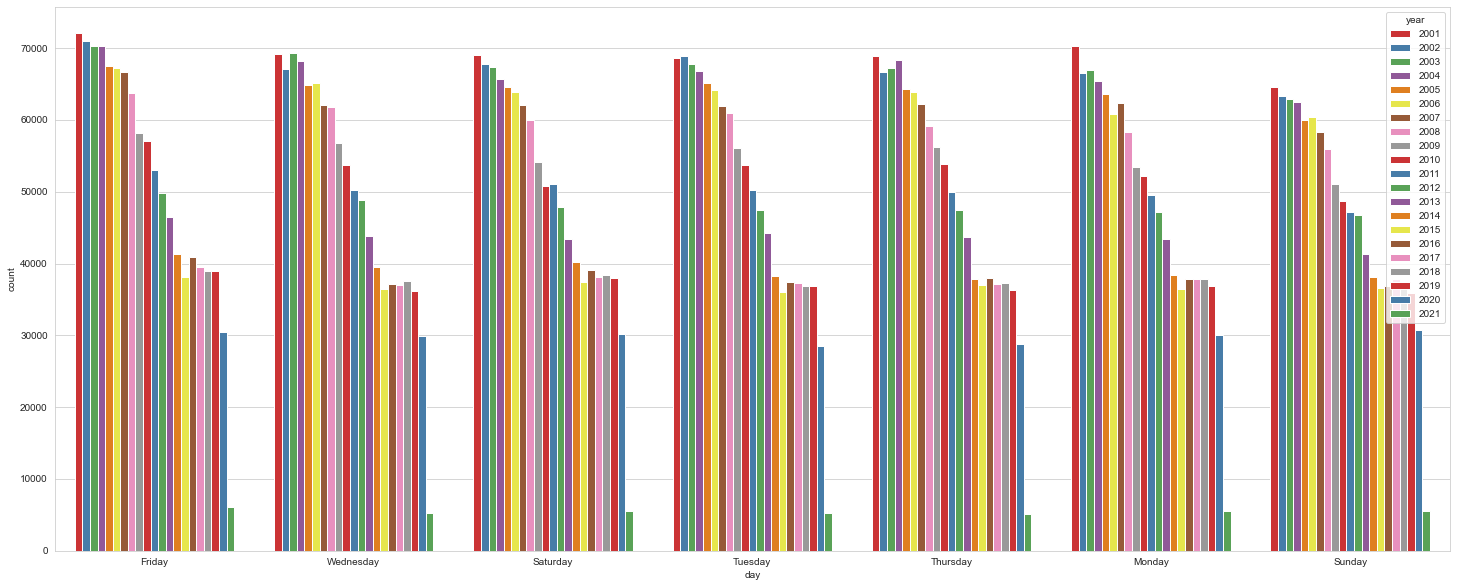

In [286]:
plt.figure(figsize=(25,10))
zone_plot = sns.countplot(data=crimes_df,x='day'
                          ,hue='year',order=crimes_df["day"].value_counts().index,palette='Set1')

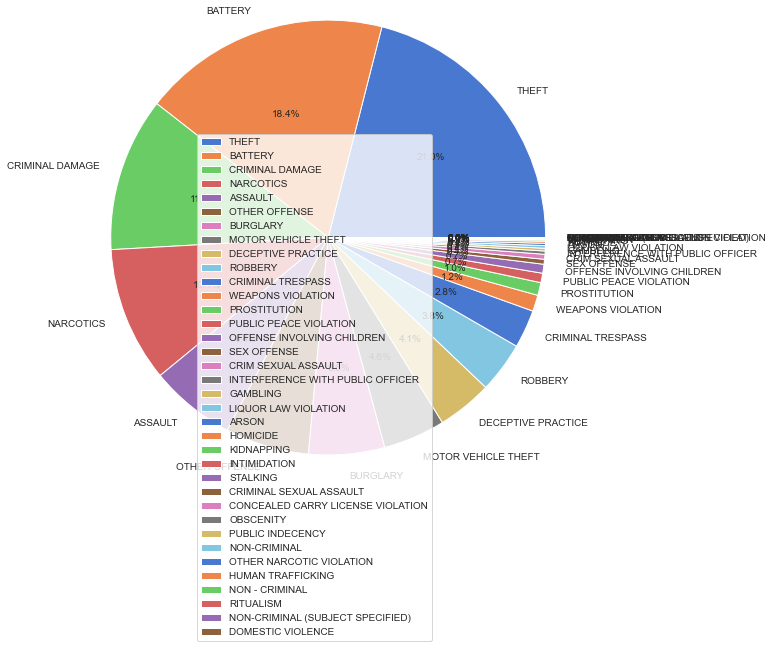

In [222]:
crimes_data_primary_type_pie = plt.pie(crimes_df.primarytype.value_counts(),labels=crimes_df.primarytype.value_counts().index,autopct='%1.1f%%',radius=2.5)
plt.legend(loc = 'best')

### Count of each crimes

[Text(0, 0, 'THEFT'),
 Text(1, 0, 'BATTERY'),
 Text(2, 0, 'CRIMINAL DAMAGE'),
 Text(3, 0, 'NARCOTICS'),
 Text(4, 0, 'ASSAULT'),
 Text(5, 0, 'OTHER OFFENSE'),
 Text(6, 0, 'BURGLARY'),
 Text(7, 0, 'MOTOR VEHICLE THEFT'),
 Text(8, 0, 'DECEPTIVE PRACTICE'),
 Text(9, 0, 'ROBBERY')]

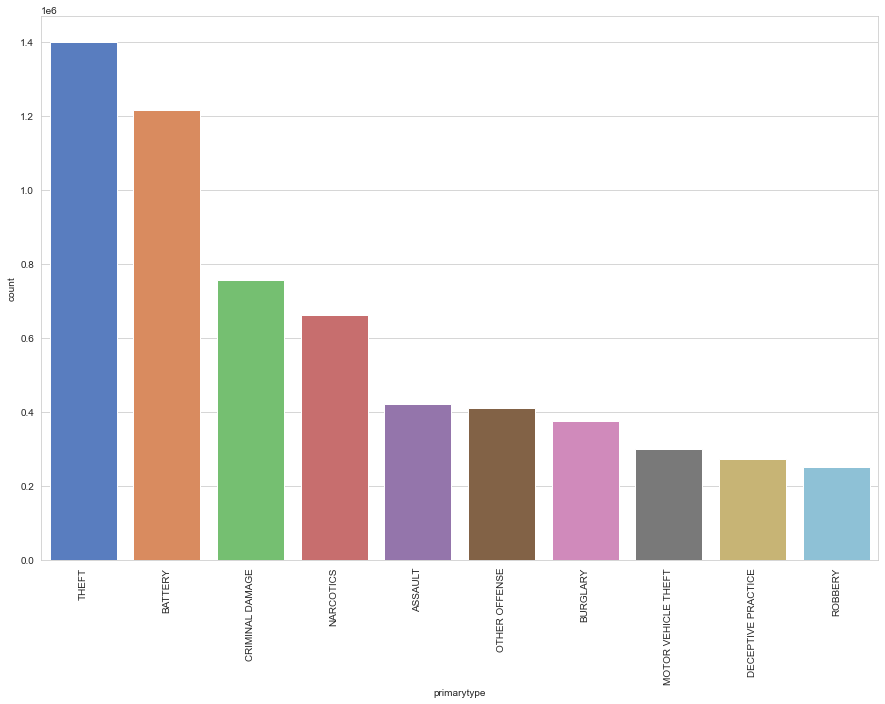

In [155]:
count=crimes_df['primarytype'].value_counts()
plt.figure(figsize = (15, 10))
sns.set_palette("muted")
plot=sns.countplot(x ='primarytype', data = crimes_df, order = count.iloc[:10].index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

### Locations where most crimes are happening

<ipython-input-174-d86398f26cda>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


[Text(0.0, 0, ''),
 Text(200000.0, 0, ''),
 Text(400000.0, 0, ''),
 Text(600000.0, 0, ''),
 Text(800000.0, 0, ''),
 Text(1000000.0, 0, ''),
 Text(1200000.0, 0, ''),
 Text(1400000.0, 0, ''),
 Text(1600000.0, 0, ''),
 Text(1800000.0, 0, '')]

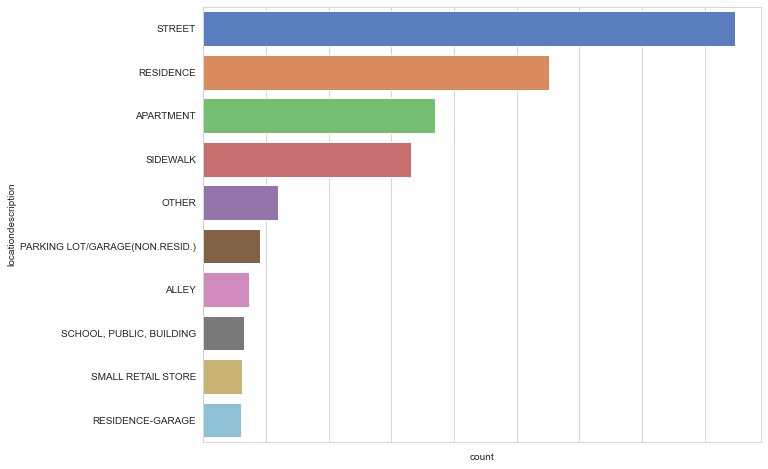

In [174]:
plt.figure(figsize = (10, 8))
sns.set_palette("muted")
count=crimes_df['locationdescription'].value_counts()
plot=sns.countplot(y ='locationdescription', data = crimes_df,order = count.iloc[:10].index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

### Trends of Crimes in the years

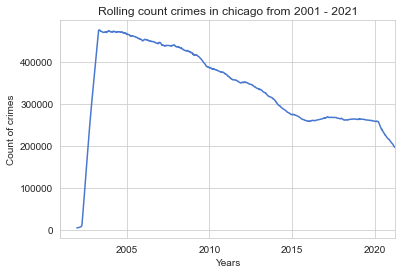

In [173]:
crimes_df, census_df=read_input()
crimes_df.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling count crimes in chicago from 2001 - 2021')
plt.ylabel('Count of crimes')
plt.xlabel('Years')
plt.show()

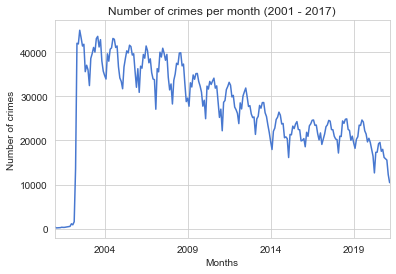

In [170]:
crimes_df, census_df=read_input()
crimes_df=crimes_df.resample('M')
crimes_df.size().plot(legend=False)
plt.title('Count of crimes in chicago monthly')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

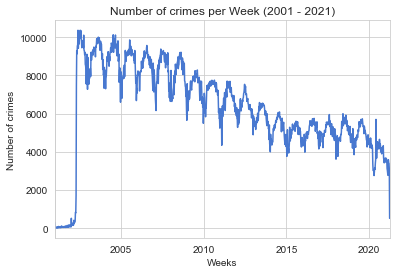

In [171]:
crimes_df, census_df=read_input()
crimes_df=crimes_df.resample('W')
crimes_df.size().plot(legend=False)
plt.title('Number of crimes per Week (2001 - 2021)')
plt.xlabel('Weeks')
plt.ylabel('Number of crimes')
plt.show()

In [ ]:
crime_data_for_trend = crimes_df.pivot_table('id', aggfunc=np.size, columns='primarytype', index=crimes_df.index.date, fill_value=1)
crime_data_for_trend.index = pd.DatetimeIndex(crime_data_for_trend.index)
plot = crime_data_for_trend.rolling(365).sum().plot(figsize=(12, 24), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

In [ ]:
'''The pattern of crimes
1.Trend of Crimes occurring over the years'''


plt.figure(figsize=(13,8))
crimes_df.resample('M').size().plot(legend=False)
plt.title('Trend of Crimes occurring over the years')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

In [ ]:
'''The pattern of crimes
1.Trend of Crimes occurring over the years'''


plt.figure(figsize=(13,8))
Crimes_copy.resample('M').size().plot(legend=False)
plt.title('Trend of Crimes occurring over the years')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

In [ ]:
'''2. Crimes happening monthwise'''
Crimes_copy.groupby([Crimes_copy.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

In [ ]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
Crimes_copy.groupby([Crimes_copy.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

In [ ]:
plt.figure(figsize=(11,4))
Crimes_copy.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2001 - 2020')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

In [ ]:
Crimes = Crimes.loc[(Crimes['X Coordinate']!=0)]
sns.lmplot('X Coordinate', 
           'Y Coordinate',
           data=Crimes[:],
           fit_reg=False, 
           hue="District",
           palette='Dark2',
           size=14,
           ci=2,
           scatter_kws={"marker": "D", 
                        "s": 10})
ax = plt.gca()
ax.set_title("All Crime Distribution per District")
plt.savefig("incorrectdistrict.png")

In [ ]:
col2 = ['Date','Primary Type','Arrest','Domestic','District','X Coordinate','Y Coordinate']
multiple_crimes = Crimes[col2]
multiple_crimes = multiple_crimes[multiple_crimes['Primary Type']\
                  .isin(['HOMICIDE','CONCEALED CARRY LICENSE VIOLATION','NARCOTICS','WEAPONS VIOLATION'])]
# clean some rouge (0,0) coordinates
multiple_crimes = multiple_crimes[multiple_crimes['X Coordinate']!=0]
multiple_crimes.head()
g = sns.lmplot(x="X Coordinate",
               y="Y Coordinate",
               col="Primary Type",
               data=multiple_crimes.dropna(), 
               col_wrap=2, size=6, fit_reg=False, 
               sharey=False,
               scatter_kws={"marker": "D",
                            "s": 10})

In [ ]:
df_public_peace =  Crimes[Crimes['Primary Type'] == 'PUBLIC PEACE VIOLATION']
df_public_data = pd.DataFrame({"Counts": df_public_peace['Description'].value_counts(), "Description" : df_public_peace['Description'].value_counts().index})
df_public_data.reset_index(inplace=True)
df_public_data = df_public_data.drop(columns=['index'], axis = 1)
df_public_data.head()
plt.figure(figsize = (15, 7))
sns.barplot(y ="Description", x = "Counts", data = df_public_data, palette="cool")